In [2]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [5]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/MSFT.csv')
df

,Date,Close
0,2/6/2014,40.790001
1,3/6/2014,40.290001
2,4/6/2014,40.320000
3,5/6/2014,41.209999
4,6/6/2014,41.480000
...,...,...
2260,23/5/2023,315.260010
2261,24/5/2023,313.850006
2262,25/5/2023,325.920013
2263,26/5/2023,332.890015


In [6]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2265 non-null   object 
 1   Close   2265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 35.5+ KB


In [7]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df = df
new_df.describe()

,Close
count,2265.000000
mean,142.370631
std,91.763318
min,40.290001
25%,57.419998
50%,108.300003
75%,231.600006
max,343.109985


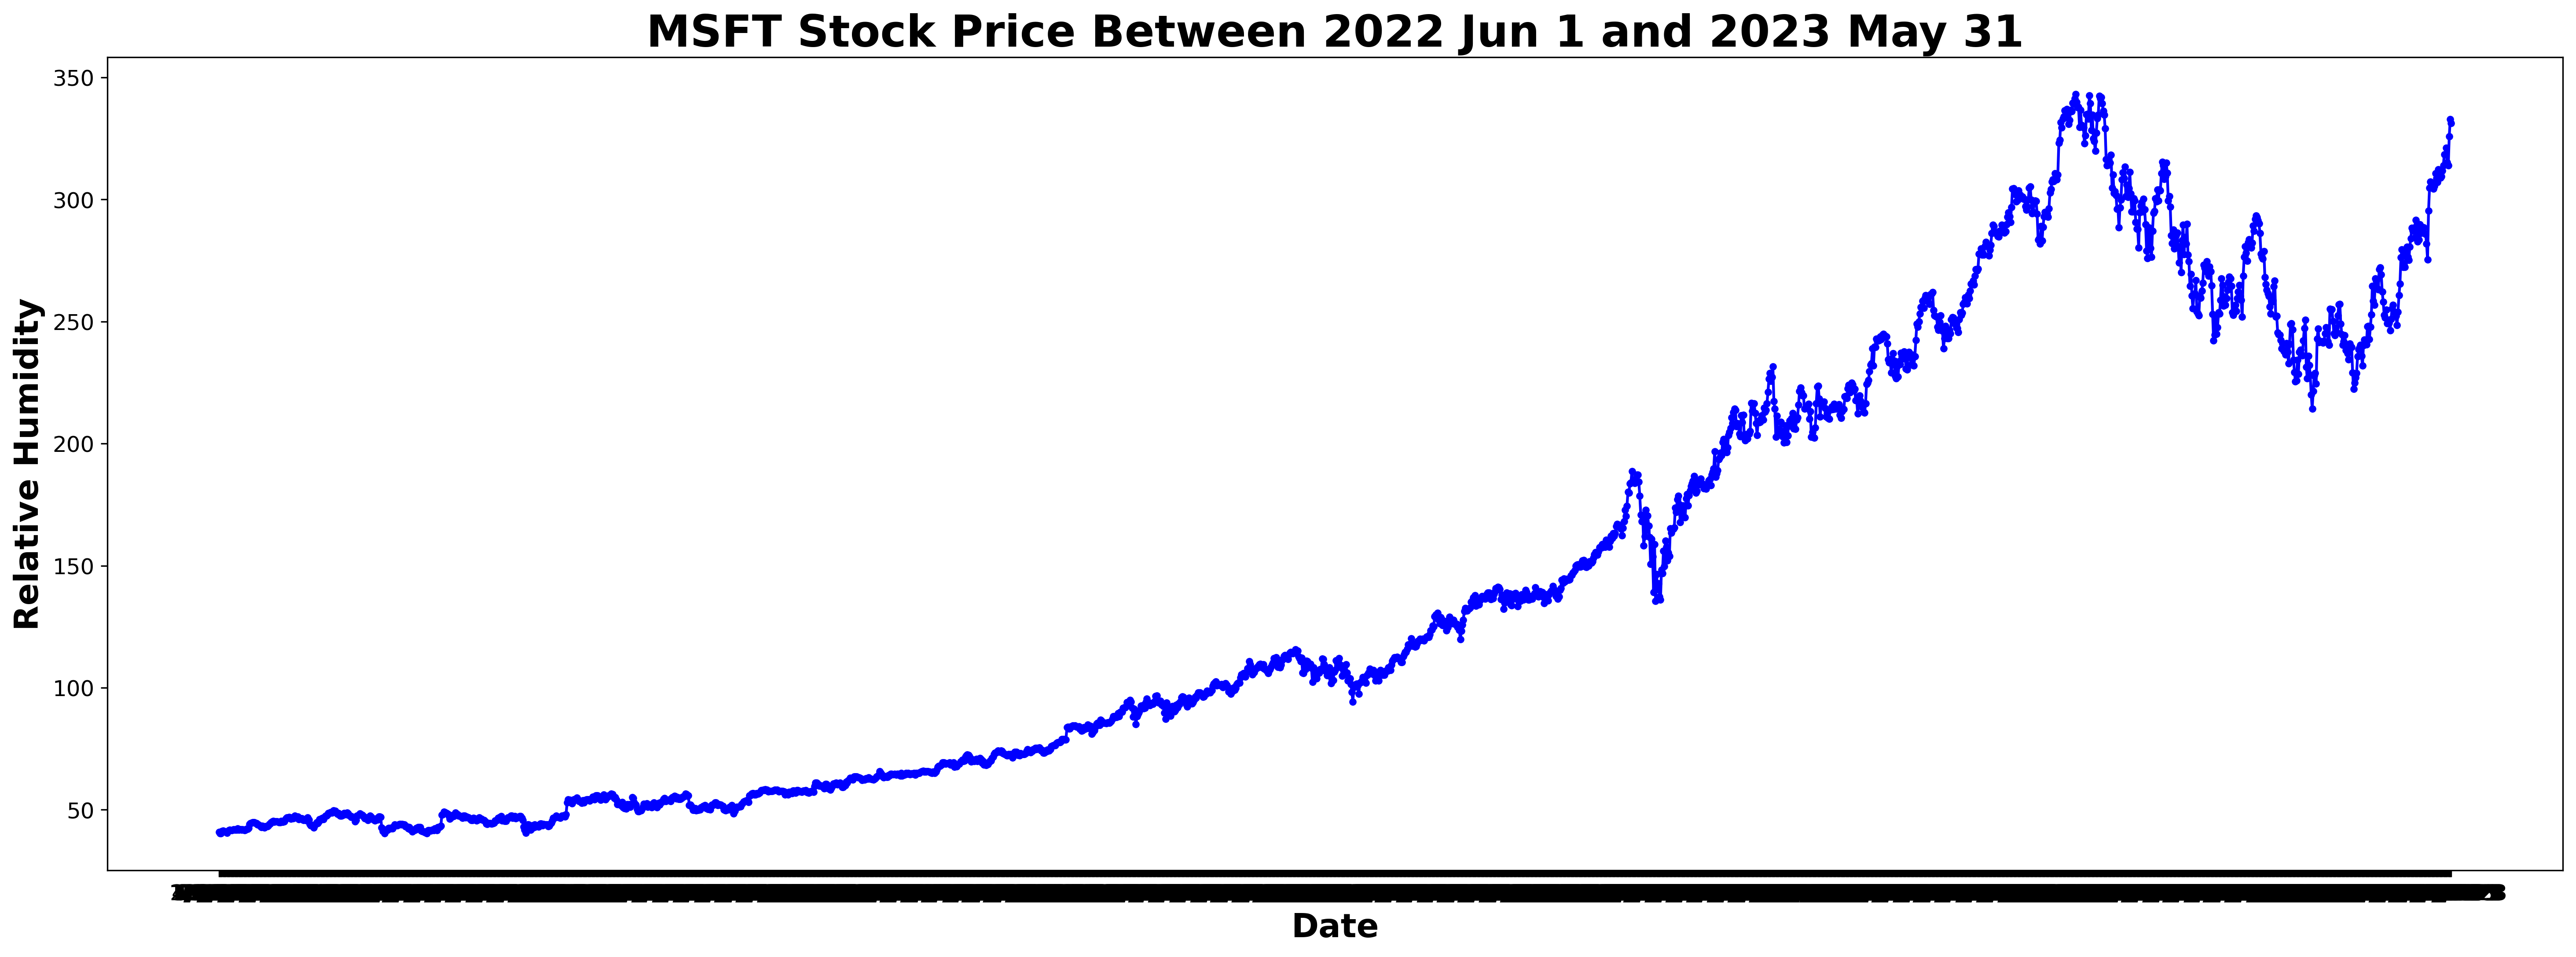

In [8]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('MSFT Stock Price Between 2022 Jun 1 and 2023 May 31',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [9]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2/6/2014,40.790001,NaN,NaN,NaN
1,3/6/2014,40.290001,40.790001,NaN,NaN
2,4/6/2014,40.320000,40.290001,40.790001,NaN
3,5/6/2014,41.209999,40.320000,40.290001,40.790001
4,6/6/2014,41.480000,41.209999,40.320000,40.290001


In [10]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,5/6/2014,41.209999,40.320000,40.290001,40.790001
1,6/6/2014,41.480000,41.209999,40.320000,40.290001
2,9/6/2014,41.270000,41.480000,41.209999,40.320000
3,10/6/2014,41.110001,41.270000,41.480000,41.209999
4,11/6/2014,40.860001,41.110001,41.270000,41.480000
...,...,...,...,...,...
2257,23/5/2023,315.260010,321.179993,318.339996,318.519989
2258,24/5/2023,313.850006,315.260010,321.179993,318.339996
2259,25/5/2023,325.920013,313.850006,315.260010,321.179993
2260,26/5/2023,332.890015,325.920013,313.850006,315.260010


In [11]:
# Train data
x=clean_df.drop(['Date','Close'],axis=1).copy()
x.head()

,Lag_1,Lag_2,Lag_3
0,40.320000,40.290001,40.790001
1,41.209999,40.320000,40.290001
2,41.480000,41.209999,40.320000
3,41.270000,41.480000,41.209999
4,41.110001,41.270000,41.480000


In [12]:
# Test data
y=clean_df['Close'].copy()
y.head()

0    41.209999
1    41.480000
2    41.270000
3    41.110001
4    40.860001
Name: Close, dtype: float64

In [13]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=False)

In [14]:
x_train_tuning,x_valid,y_train_tuining,y_valid = train_test_split(x_train,y_train,test_size=0.2,shuffle=False)

In [15]:
##1
#set x (make prediction)
# Train
#x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train_tuning)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train

,0,1,2
0,0.000202,0.000000,0.003369
1,0.006199,0.000202,0.000000
2,0.008018,0.006199,0.000202
3,0.006603,0.008018,0.006199
4,0.005525,0.006603,0.008018
...,...,...,...
1442,0.875143,0.860993,0.879995
1443,0.794353,0.875143,0.860993
1444,0.820160,0.794353,0.875143
1445,0.892797,0.820160,0.794353


In [16]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})
#get_custom_objects().update({'my_MAPE': MRAE_calculate})

In [17]:
def create_model(learning_rate=0.01):
  # 6.1 Create the model
  clear.clear_session()
  model=Sequential()

  # 6.2 Add input layer & first hidden layer
  model.add(GRU(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

  model.add(GRU(units = 50))

  # 6.5 Add output layer
  model.add(Dense(units=1, activation='linear'))

  # 6.6 Compile the defined Net
  #opt=SGD(learning_rate=0.001,momentum=0.5)
  opt=Adam(learning_rate=learning_rate,beta_1=0.95)
  model.compile(loss='MSE',optimizer=opt, metrics=['mean_absolute_percentage_error'])

  # Finally check the model
  return model

model = KerasRegressor(build_fn=create_model, epochs=100,verbose=0)
cv_inner = TimeSeriesSplit(n_splits=3)
learning_rate = [0.01,0.001,0.0001]
batch_size = [32,64]
param_grid = dict(batch_size=batch_size,learning_rate=learning_rate)
grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=cv_inner,scoring='neg_root_mean_squared_error',n_jobs=-1)
grid_result = grid.fit(scaled_x_train,y_train_tuining)

print("Best:%fusing%s"%(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<ipython-input-17-dd1dc7997bfd>:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100,verbose=0)


Best:-33.979292using{'batch_size': 32, 'learning_rate': 0.001}
-40.549394 (23.648789) with: {'batch_size': 32, 'learning_rate': 0.01}
-33.979292 (14.848326) with: {'batch_size': 32, 'learning_rate': 0.001}
-70.697525 (26.634799) with: {'batch_size': 32, 'learning_rate': 0.0001}
-40.797721 (23.908330) with: {'batch_size': 64, 'learning_rate': 0.01}
-45.664082 (21.155853) with: {'batch_size': 64, 'learning_rate': 0.001}
-76.676999 (28.551319) with: {'batch_size': 64, 'learning_rate': 0.0001}


In [18]:
# Train data
Forecast_train_data=clean_df.iloc[0:1812,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,5/6/2014,41.209999,40.320000,40.290001,40.790001
1,6/6/2014,41.480000,41.209999,40.320000,40.290001
2,9/6/2014,41.270000,41.480000,41.209999,40.320000
3,10/6/2014,41.110001,41.270000,41.480000,41.209999
4,11/6/2014,40.860001,41.110001,41.270000,41.480000
...,...,...,...,...,...
1807,9/8/2021,288.329987,289.459991,289.519989,286.510010
1808,10/8/2021,286.440002,288.329987,289.459991,289.519989
1809,11/8/2021,286.950012,286.440002,288.329987,289.459991
1810,12/8/2021,289.809998,286.950012,286.440002,288.329987


In [19]:
# Test data
Forecast_test_data=clean_df.iloc[1812:2265,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
1812,16/8/2021,294.600006,292.850006,289.809998,286.950012
1813,17/8/2021,293.079987,294.600006,292.850006,289.809998
1814,18/8/2021,290.730011,293.079987,294.600006,292.850006
1815,19/8/2021,296.769989,290.730011,293.079987,294.600006
1816,20/8/2021,304.359985,296.769989,290.730011,293.079987
...,...,...,...,...,...
2257,23/5/2023,315.260010,321.179993,318.339996,318.519989
2258,24/5/2023,313.850006,315.260010,321.179993,318.339996
2259,25/5/2023,325.920013,313.850006,315.260010,321.179993
2260,26/5/2023,332.890015,325.920013,313.850006,315.260010


In [20]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [21]:
# 6.1 Create the model
clear.clear_session()
Fmodel=Sequential()

# 6.2 Add input layer & first hidden layer
Fmodel.add(GRU(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
Fmodel.add(Dropout(0.2))
Fmodel.add(GRU(units = 50))

# 6.5 Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.001,beta_1=0.95)
Fmodel.compile(loss='MSE',optimizer=opt, metrics=['mean_absolute_percentage_error'])

Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 50)             7950      
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=100, batch_size=32,verbose=1)

Epoch 1/100
57/57 [==============================] - 3s 6ms/step - loss: 14764.3730 - mean_absolute_percentage_error: 91.5430
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 13464.1699 - mean_absolute_percentage_error: 83.0426
Epoch 3/100
57/57 [==============================] - 0s 7ms/step - loss: 12856.1162 - mean_absolute_percentage_error: 78.9160
Epoch 4/100
57/57 [==============================] - 0s 7ms/step - loss: 12305.7578 - mean_absolute_percentage_error: 75.1180
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 11798.7676 - mean_absolute_percentage_error: 71.3570
Epoch 6/100
57/57 [==============================] - 0s 8ms/step - loss: 11322.9893 - mean_absolute_percentage_error: 67.6884
Epoch 7/100
57/57 [==============================] - 0s 7ms/step - loss: 10871.4150 - mean_absolute_percentage_error: 64.1803
Epoch 8/100
57/57 [==============================] - 0s 7ms/step - loss: 10447.1084 - mean_absolute_percentage_error: 

In [23]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('House_Rent_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [24]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/House_Rent_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


In [25]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [26]:
# 8.1 Make prediction
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [27]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
1812,16/8/2021,294.600006,193.179993,101.420013
1813,17/8/2021,293.079987,193.179993,99.899994
1814,18/8/2021,290.730011,193.179993,97.550018
1815,19/8/2021,296.769989,193.179993,103.589996
1816,20/8/2021,304.359985,193.179993,111.179992
...,...,...,...,...
2257,23/5/2023,315.260010,193.179993,122.080017
2258,24/5/2023,313.850006,193.179993,120.670013
2259,25/5/2023,325.920013,193.179993,132.740020
2260,26/5/2023,332.890015,193.179993,139.710022


In [28]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 86.742
MSE: 8487.411
RMSE: 92.127
MAPE: 30.131 %
SMAPE: 35.967 %
RAE: 3.289
MRAE: 0.007307919558214962
MdRAE: 3.797 bench: 279.922
RSE: 8.812
RRSE: 2.969


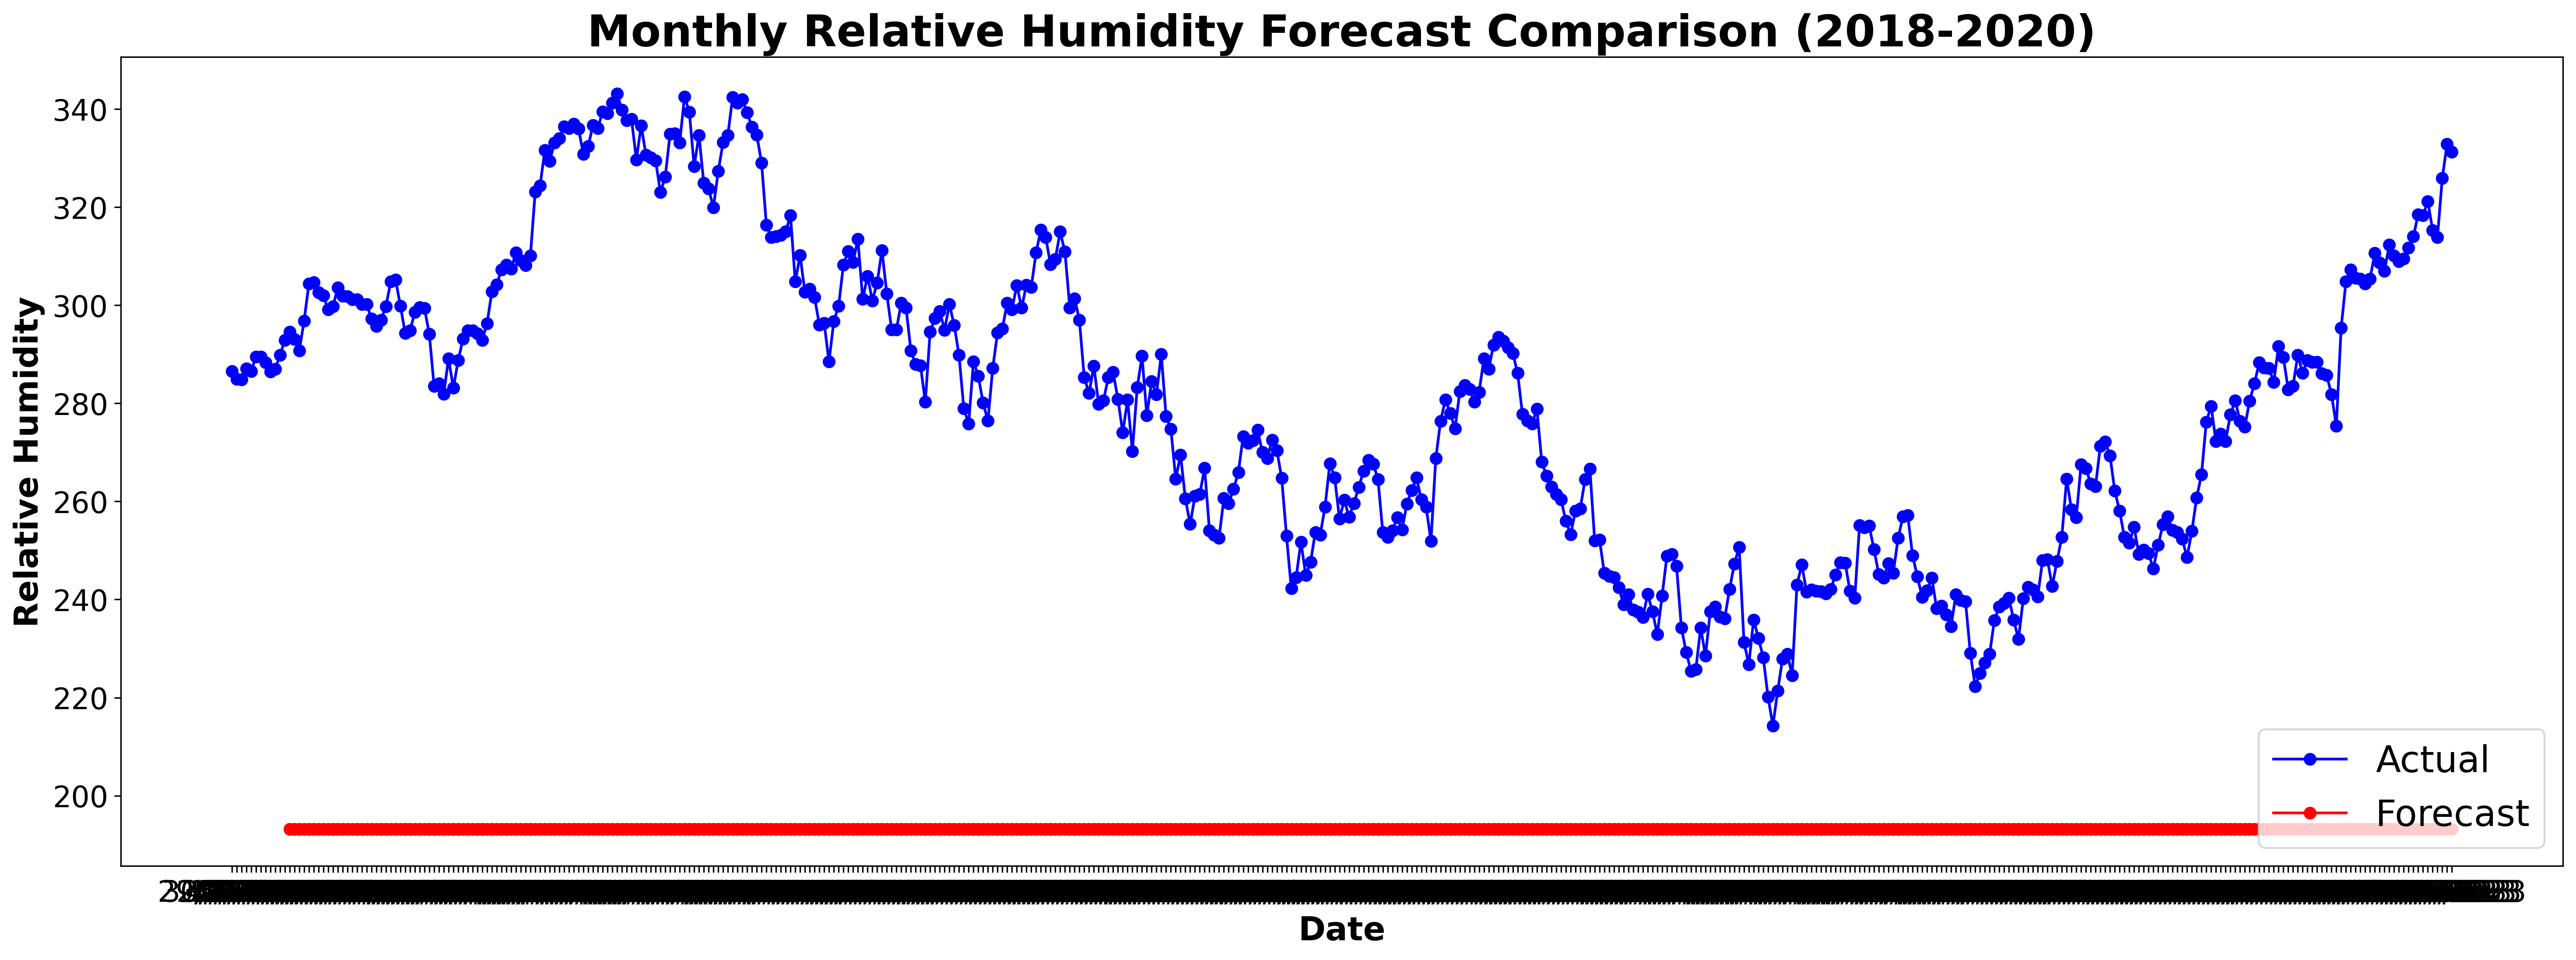

In [29]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity Forecast Comparison (2018-2020)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[1800:,0],clean_df.iloc[1800:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

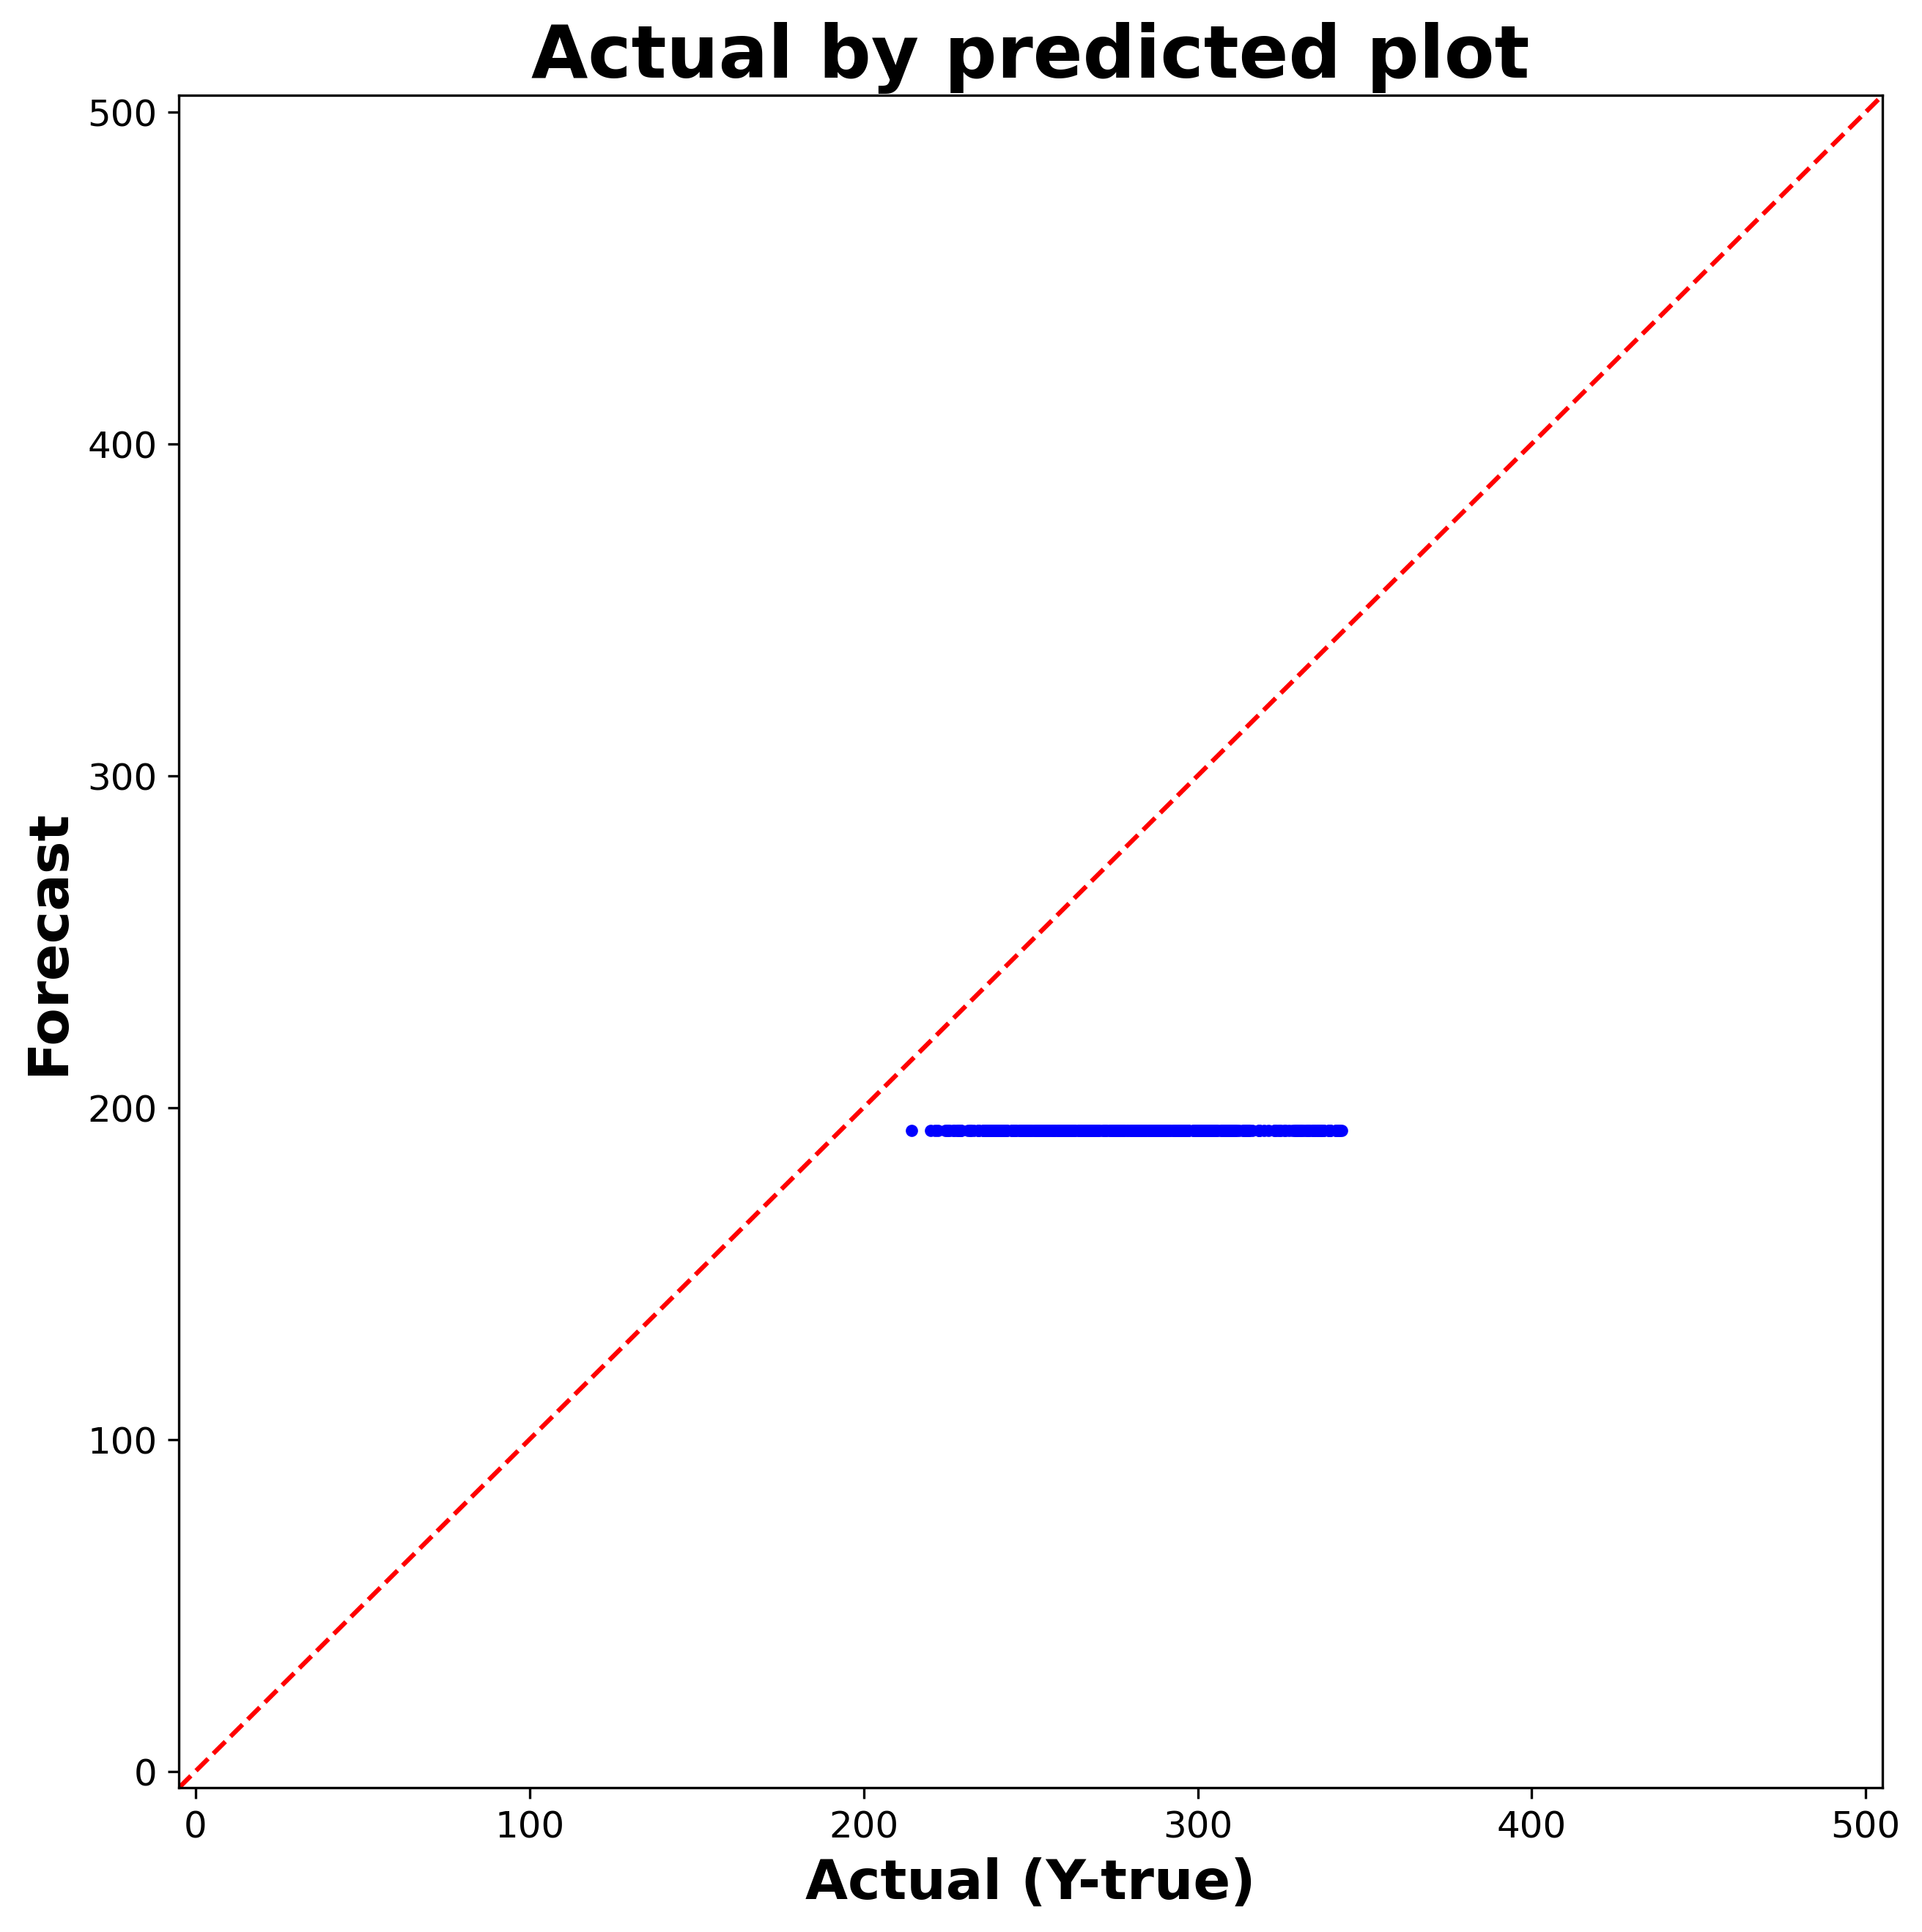

In [30]:
# Lock the scale of axis by Y_true
max_value=500+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()